<a href="https://colab.research.google.com/github/Jachmi03/lecture/blob/main/Uczenie_maszynowe_rekomendacje.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#rekomendacje


In [5]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
!unzip ml-latest-small

Archive:  ml-latest-small.zip
replace ml-latest-small/links.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')

In [8]:
movies.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [30]:
print(ratings['rating'].count())


100836


In [28]:
print(movies['movieId'].nunique())


9742


In [32]:
print(ratings['userId'].nunique())


610


In [34]:
print(ratings['userId'].value_counts().mean())


165.30491803278687


In [35]:
print(ratings['movieId'].value_counts().mean())

10.369806663924312


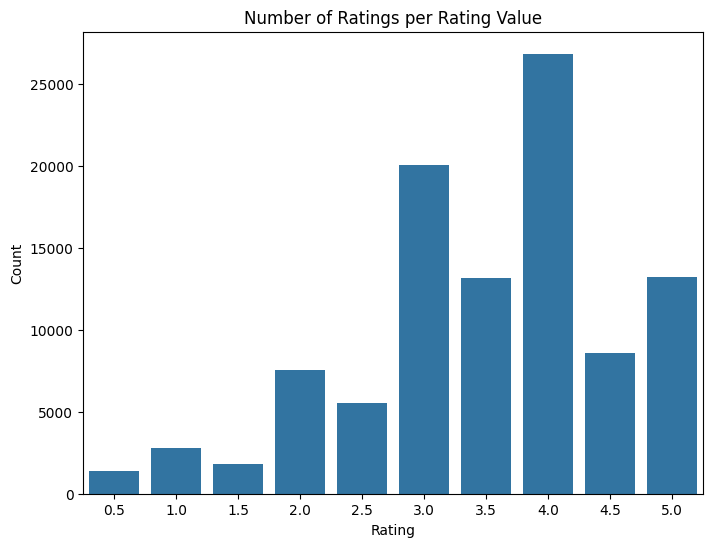

In [38]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))
sns.countplot(x='rating', data=ratings)
plt.title('Number of Ratings per Rating Value')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


In [10]:
movie_title_dict = dict(zip(movies['movieId'], movies['title']))

def get_movie_title(movie_id):
  return movie_title_dict.get(movie_id)


In [11]:
C = ratings['rating'].count().mean()
m = ratings['rating'].mean()

def bayesian_avg(ratings):
  bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
  return bayesian_avg

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movies.merge(bayesian_avg_ratings, on='movieId')

print(movie_stats.head(10))

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   
5        6                         Heat (1995)   
6        7                      Sabrina (1995)   
7        8                 Tom and Huck (1995)   
8        9                 Sudden Death (1995)   
9       10                    GoldenEye (1995)   

                                        genres  bayesian_avg  
0  Adventure|Animation|Children|Comedy|Fantasy      3.502449  
1                   Adventure|Children|Fantasy      3.501481  
2                               Comedy|Romance      3.501432  
3                         Comedy|Drama|Romance      3.501478  
4                                       Comedy      3.501348  
5                        Action|Crime|Thriller      3.502006  
6       

In [1]:
!pip install surprise

In [2]:
!pip install numpy==1.24.3

In [3]:
from surprise.model_selection import cross_validate, GridSearchCV
from surprise.prediction_algorithms import SVD, KNNBasic, KNNBaseline
from surprise import Dataset
from surprise import Reader

In [12]:
min_rating = ratings.rating.min()
max_rating = ratings.rating.max()
reader = Reader(rating_scale=(min_rating,max_rating))
data = Dataset.load_from_df(ratings[['userId','movieId', 'rating']], reader)

In [23]:
algo = SVD()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8645  0.8730  0.8648  0.8797  0.8749  0.8714  0.0059  
MAE (testset)     0.6633  0.6725  0.6672  0.6734  0.6703  0.6693  0.0037  
Fit time          2.24    1.48    2.03    1.41    1.44    1.72    0.34    
Test time         0.24    0.12    0.11    0.11    0.10    0.14    0.05    


{'test_rmse': array([0.86450434, 0.87297912, 0.86484852, 0.87969367, 0.8748858 ]),
 'test_mae': array([0.66332256, 0.67245931, 0.66715774, 0.6733954 , 0.67028106]),
 'fit_time': (2.241063356399536,
  1.4804887771606445,
  2.0255753993988037,
  1.411438226699829,
  1.4415624141693115),
 'test_time': (0.2429502010345459,
  0.11976218223571777,
  0.10563945770263672,
  0.1135094165802002,
  0.10459613800048828)}

In [26]:
trainset = data.build_full_trainset()
algo.fit(trainset)

# User ID
user_id = 600

rated_movies = ratings[ratings['userId'] == user_id]['movieId'].tolist()

all_movies = movies['movieId'].tolist()

unrated_movies = [movie for movie in all_movies if movie not in rated_movies]
predictions = []

for movie_id in unrated_movies:
    prediction = algo.predict(user_id, movie_id)
    predictions.append((movie_id, prediction.est))


predictions.sort(key=lambda x: x[1], reverse=True)

print(f"Top 10 recommendations for user {user_id}:")
for movie_id, rating in predictions[:10]:
    title = get_movie_title(movie_id)
    print(f"{title}: {rating}")

Top 10 recommendations for user 600:
Jaws (1975): 4.377705438619943
Lost in Translation (2003): 4.187868075636481
Room (2015): 4.10825614435646
One Flew Over the Cuckoo's Nest (1975): 4.107424023713233
Departed, The (2006): 4.107055345599379
In Bruges (2008): 4.085490345186972
Hot Fuzz (2007): 4.076945197835824
Dazed and Confused (1993): 4.067348497288931
WALL·E (2008): 4.044317349285455
Boondock Saints, The (2000): 4.03066001905442
